[*********************100%***********************]  5 of 5 completed


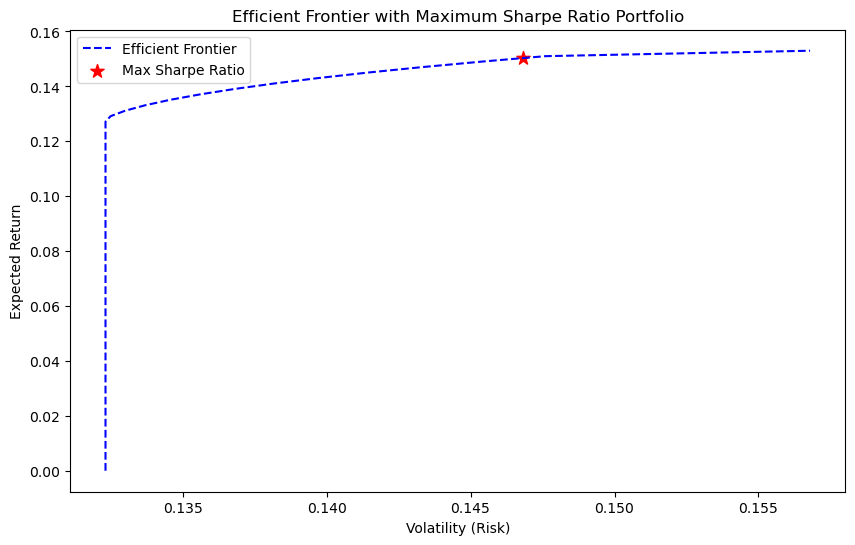

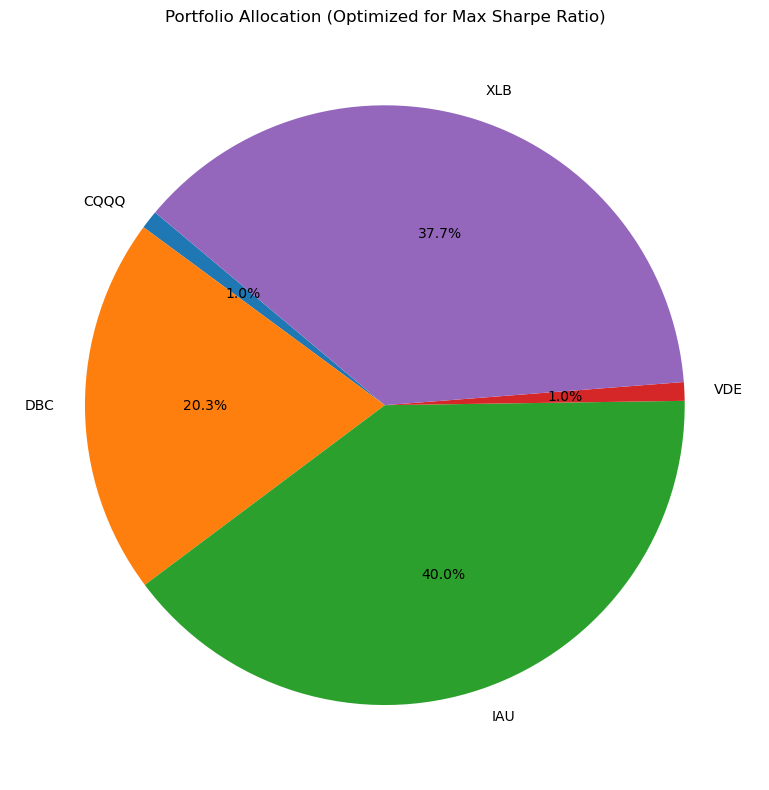

Expected Return: 0.1503298019805117
Volatility: 0.14682035127931925
Sharpe Ratio: 0.8876821288389715
Weights: OrderedDict([('CQQQ', 0.01), ('DBC', 0.20341), ('IAU', 0.4), ('VDE', 0.01), ('XLB', 0.37659)])


In [16]:
# Portfolio Optim Module Example

import yfinance as yf
from pypfopt import EfficientFrontier, risk_models, expected_returns
import matplotlib.pyplot as plt
import numpy as np

# Clear any style-related settings in matplotlib
plt.rcdefaults()
plt.style.use('default')

# Define stock symbols and fetch data
tickers = ['IAU', 'VDE', 'XLB', 'DBC', 'CQQQ']
data = yf.download(tickers, start="2018-12-01", end="2021-12-31")['Adj Close']

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)

# Initialize the Efficient Frontier object and add constraints before optimization
ef = EfficientFrontier(mu, S)
ef.add_constraint(lambda w: w <= 0.4)  # No asset can have more than 40%
ef.add_constraint(lambda w: w >= 0.01)  # No ETF can have less than 1%


# Maximize the Sharpe ratio
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

# Get performance metrics
expected_return, volatility, sharpe_ratio = ef.portfolio_performance()

# Calculate the maximum possible portfolio return for the range of target returns
max_return = mu.max()  # Upper bound for target returns to avoid ValueError

# Efficient Frontier - Manual Plot
target_returns = np.linspace(0, max_return, 100)  # Use max achievable return as the upper limit
risks = []
for target_return in target_returns:
    ef = EfficientFrontier(mu, S)  # Reinitialize to avoid constraint conflict
    ef.add_constraint(lambda w: w <= 0.4)
    ef.add_constraint(lambda w: w >= 0.01)
    try:
        ef.efficient_return(target_return)
        risks.append(np.sqrt(np.dot(ef.weights.T, np.dot(S, ef.weights))))
    except ValueError:
        # Skip returns that can't be achieved
        continue

# Plot Efficient Frontier
plt.figure(figsize=(10, 6))
plt.plot(risks, target_returns[:len(risks)], 'b--', label="Efficient Frontier")
plt.scatter(volatility, expected_return, marker="*", color="r", s=100, label="Max Sharpe Ratio")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.legend()
plt.title("Efficient Frontier with Maximum Sharpe Ratio Portfolio")

# Display weights pie chart
fig, ax = plt.subplots(figsize=(8, 8))
labels = cleaned_weights.keys()
sizes = cleaned_weights.values()
ax.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
ax.set_title("Portfolio Allocation (Optimized for Max Sharpe Ratio)")

plt.tight_layout()
plt.show()

# Display calculated portfolio performance and weights
print("Expected Return:", expected_return)
print("Volatility:", volatility)
print("Sharpe Ratio:", sharpe_ratio)
print("Weights:", cleaned_weights)
